## Replicate two bank example figures from Eric Shaanning's thesis

In [1]:
using Pkg
# change this if the path is different
path_to_FinNetValu = "/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/"
Pkg.activate(path_to_FinNetValu)

"/Users/wolfgang/Desktop/Uni/HIWI/Bertschinger/SysRisk/Code/FinNetValu/Project.toml"

In [10]:
using FinNetValu
using LaTeXStrings
using Plots
#pyplot()

In [3]:
Π = hcat([90.; 70.])
Θ = [10. 0.; 0. 20.]
C = [4., 4.5]
λ_max = 33
λ_target = 0.95*λ_max
ϵ = [0.2, 0.0]
S = [1.]
B = [0.5*S[1]]
ADV = [50.]
σ = [0.02]
c = 0.4
τ = 20.
α = 1. # not specified exactly for two bank example, α = 1. creates similar plots

1.0

In [4]:
# helper functions
"""
    runkrounds_121(csmodel, k)
Simulates k rounds of deleveraging given the initial CSModel. Returns the
deleveraging proportions of 1st bank and the losses of second bank over k
rounds.
"""
function runkrounds_121(csmodel::CSModel, Θ, ϵ, k::Int)
    Γ = ones(k)
    L = ones(k)
    # intial a
    a = FinNetValu.init_a(csmodel, Θ, ϵ)
    # initial current state
    x = FinNetValu.init(csmodel, a)

    for j in 1:k
        # deleveraging proportion before sales
        Γ[j] = FinNetValu.delevprop(csmodel, x, a)[1]
        tmp = deepcopy(FinNetValu.Cview(csmodel, x)[2])
        # current state updated after deleveraging round
        x = valuation(csmodel, x, a)
        L[j] = tmp-FinNetValu.Cview(csmodel, x)[2]
    end
    return Γ, L
end

"""
    runkrounds_122(csmodel, k)
Simulates k rounds of deleveraging given the initial CSModel. Returns the
deleveraging proportions of both banks over k rounds.
"""
function runkrounds_122(csmodel::CSModel, Θ, ϵ, k::Int)
    Γ_A = ones(k)
    Γ_B = ones(k)
    # intial a
    a = FinNetValu.init_a(csmodel, Θ, ϵ)
    # initial current state
    x = FinNetValu.init(csmodel, a)

    for j in 1:k
        # deleveraging proportion before sales
        tmp = FinNetValu.delevprop(csmodel, x, a)
        Γ_A[j] = tmp[1]
        Γ_B[j] = tmp[2]
        # current state updated after deleveraging round
        x = valuation(csmodel, x, a)
    end
    return Γ_A, Γ_B
end

"""
    varyshockskrounds(; ϵ1_all=collect(0:0.005:0.45), k=5)
Sweeps over a range of initial shock values of asset class 1 and simulates k
rounds of deleveraging for each shock value.
"""
function varyshockskrounds(;ϵ1_all=collect(0:0.001:0.45), k=5, figure=121)
    if figure == 121
        Γ = ones(size(ϵ1_all, 1), k)
        L = ones(size(ϵ1_all, 1), k)

        for i in 1:size(ϵ1_all, 1)
            csmodel = CSModel(Π, C, B, S, ADV, σ, c, τ,
                                    λ_max, λ_target=λ_target, α=α)

            Γ[i, :], L[i, :] = runkrounds_121(csmodel, Θ, [ϵ1_all[i], 0.], k)
        end
        return Γ, L, ϵ1_all
    elseif figure == 122
        Γ_A = ones(size(ϵ1_all, 1), k)
        Γ_B = ones(size(ϵ1_all, 1), k)

        for i in 1:size(ϵ1_all, 1)
            csmodel = CSModel(Π, C, B, S, ADV, σ, 0.3*c, τ,
                                    λ_max, λ_target=λ_target, α=α)

            Γ_A[i, :], Γ_B[i, :] = runkrounds_122(csmodel, Θ, [ϵ1_all[i], 0.], k)
        end
        return Γ_A, Γ_B, ϵ1_all
    end
end

"""
    visualizeinsolvencyilliquidity(;ϵ1_all=collect(0:0.01:0.45),
                                        sf=collect(0.3:0.01:1.))
Sweeps over all combinations of ϵ1_all and sf, the market depth scaling factor,
and runs the cascade of fire sales until a fixed point is reached. A heatmap is
created indicating whether a bank is insolvent (=-60), illiquid (=0) or all
right (=60).
"""
function visualizeinsolvencyilliquidity(;ϵ1_all=collect(0:0.01:0.45),
                                        sf=collect(0.3:0.01:1.))
    map = 60*ones(Int64, size(sf, 1), size(ϵ1_all, 1), 2)
    for i in 1:size(sf, 1)
        for j in 1:size(ϵ1_all, 1)
            csmodel = CSModel(Π, C, B, S, ADV, σ,
                                    c*sf[i], τ, λ_max, λ_target=λ_target, α=α)
            # run fire sales cascade, store fixed point
            a = FinNetValu.init_a(csmodel, Θ, [ϵ1_all[j], 0.])
            fp = fixvalue(csmodel, a)

            # compute whether banks illiquid or solvent after cascade
            # give specific code for illiquid and insolvent
            map[i, j, illiquid(csmodel, fp)] .= 0.
            map[i, j, .!solvent(csmodel, fp)] .= -60.
        end
    end
    return map, ϵ1_all, sf
end

visualizeinsolvencyilliquidity

## Replicate Figure 1.2.1 of Thesis

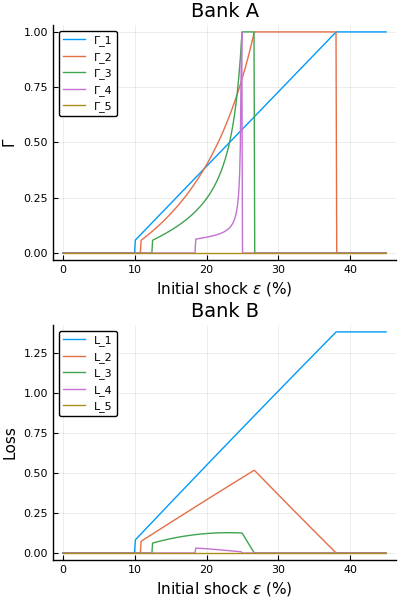

In [19]:
# simulate k rounds of deleveraging and fire sales
Γ, L, x = varyshockskrounds(k=5, figure=121)

row, col = size(Γ)

p1 = plot(x*100, Γ, xlabel=L"Initial shock $\epsilon$ (%)", ylabel=L"$\Gamma$",
            title="Bank A", label=hcat(["Γ_$(i)" for i in 1:col]...));
p2 = plot(x*100, L, xlabel=L"Initial shock $\epsilon$ (%)", ylabel="Loss",
            title="Bank B", label=hcat(["L_$(i)" for i in 1:col]...));
plot(p1,p2, layout=(2,1), size=(400, 600))

In [20]:
# Approximately 1.4 in Shaanning's thesis
print(string("L1 of Bank B: ", L[end, 1])," (should be approx 1.4 as in thesis)")

L1 of Bank B: 1.38074938434112 (should be approx 1.4 as in thesis)

## Replicate Figure 1.2.2 of Thesis

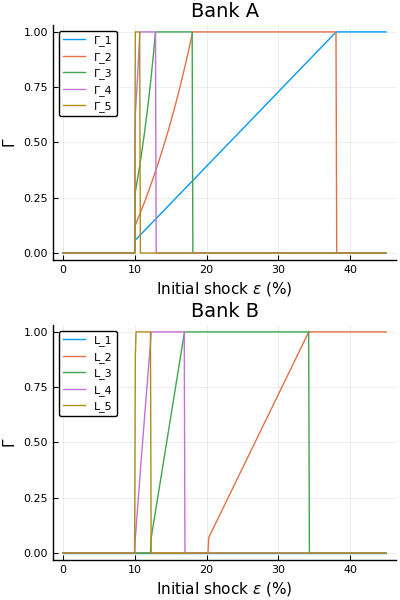

In [17]:
# simulate k rounds of deleveraging and fire sales
Γ_A, Γ_B, x = varyshockskrounds(k=5, figure=122)

row, col = size(Γ_A)

p1 = plot(x*100, Γ_A, xlabel=L"Initial shock $\epsilon$ (%)", ylabel=L"$\Gamma$",
            title="Bank A", label=hcat(["Γ_$(i)" for i in 1:col]...));
p2 = plot(x*100, Γ_B, xlabel=L"Initial shock $\epsilon$ (%)", ylabel=L"$\Gamma$",
            title="Bank B", label=hcat(["L_$(i)" for i in 1:col]...));
p = plot(p1,p2, layout=(2,1), size=(400, 600))

## Replicate Figure 1.2.4 of Thesis

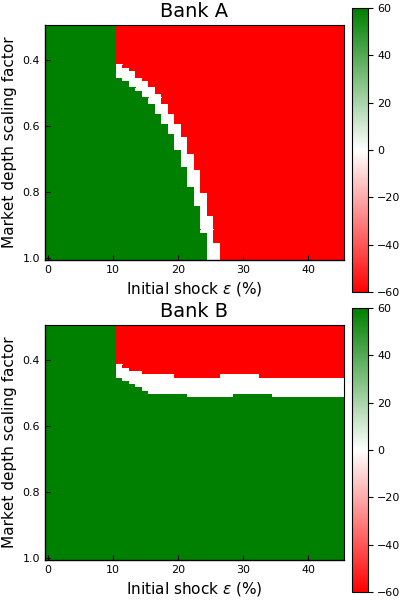

In [22]:
insolmap, xs, ys = visualizeinsolvencyilliquidity()

# green = all right, white = illiquid, red = insolvent
p1 = heatmap(xs*100, ys, insolmap[:,:,1], yflip=true,
            c=cgrad([:red,:white,:green]),
            colorbar = :right,
            grid=false,
            border=nothing,
            xlabel=L"Initial shock $\epsilon$ (%)",
            ylabel="Market depth scaling factor",
            title="Bank A");
p2 = heatmap(xs*100, ys, insolmap[:,:,2], yflip=true,
            c=cgrad([:red,:white,:green]),
            colorbar = :right,
            grid=false,
            border=nothing,
            xlabel=L"Initial shock $\epsilon$ (%)",
            ylabel="Market depth scaling factor",
            title="Bank B");
p = plot(p1,p2, layout=(2,1), size=(400, 600), dpi=100)